In [2]:
import matplotlib.pyplot as plt
import os
import random
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
from PIL import Image

print(tf.config.list_physical_devices('GPU'))
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
tf.config.set_visible_devices(gpu_devices[0:], 'GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])
print("TensorFlow cuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Num GPUs Available:  1
TensorFlow CUDA version: 64_112
TensorFlow cuDNN version: 64_8


[Classification](#Classification)

# Segmentation

In [4]:
# read data
folder = os.listdir('./brain-tumor-segmentation')
folder.sort()
folder

# Sort the image and mask filenames to ensure they match
imagepath = './brain-tumor-segmentation/images'
maskpath = './brain-tumor-segmentation/masks'

image_files = sorted(os.listdir(imagepath))
mask_files = sorted(os.listdir(maskpath))

print(image_files[:5])
print(mask_files[:5])

['1.png', '10.png', '100.png', '1000.png', '1001.png']
['1.png', '10.png', '100.png', '1000.png', '1001.png']


In [5]:
def display_images_masks(imagepath, maskpath):
    count = 0
    for image_file, mask_file in zip(image_files, mask_files):
        if count >= 2:
            break
    
        img_size=(256, 256)
        img = tf.io.read_file(imagepath + '/' + image_file)
        img = tf.image.decode_jpeg(img, channels=1)  # For grayscale
        img = tf.image.resize(img, img_size) / 255.0  # Normalize to [0, 1]
    
        mask = tf.io.read_file(maskpath + '/' + mask_file)
        mask = tf.image.decode_jpeg(mask, channels=1)  # For grayscale
        mask = tf.image.resize(mask, img_size) / 255.0  # Normalize to [0, 1]
    
        overlay = np.zeros_like(img)
        overlay[mask > 0] = 1
    
        combined = img * 0.8 + overlay * 0.2
    
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
        ax = axes[0]
        ax.imshow(img, cmap='gray')
        ax.set_title('Image')
        ax.set_axis_off()
    
        ax = axes[1]
        ax.imshow(mask, cmap='gray')
        ax.set_title('Mask')
        ax.set_axis_off()
    
        ax = axes[2]
        ax.imshow(combined, cmap='gray')
        ax.set_title('Overlay')
        ax.set_axis_off()
    
        count += 1

In [6]:
# Define paths to the images and masks directories
images_dir = './brain-tumor-segmentation/images'
masks_dir = './brain-tumor-segmentation/masks'

image_paths = sorted([os.path.join(images_dir, fname) for fname in os.listdir(images_dir)])
mask_paths = sorted([os.path.join(masks_dir, fname) for fname in os.listdir(masks_dir)])

paired_paths = list(zip(image_paths, mask_paths))
random.shuffle(paired_paths)
image_paths, mask_paths = zip(*paired_paths)
image_paths, mask_paths = list(image_paths), list(mask_paths)

train_size = int(0.8 * len(image_paths))
train_image_paths = image_paths[:train_size]
train_mask_paths = mask_paths[:train_size]
test_image_paths = image_paths[train_size:]
test_mask_paths = mask_paths[train_size:]

# Create datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))

# Define a function to load and preprocess the images and masks
def load_and_preprocess_image(img_path, mask_path, img_size=(256, 256)):
    # Load image and mask
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=1)  # For grayscale
    img = tf.image.resize(img, img_size) / 255.0  # Normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)  # For grayscale
    mask = tf.image.resize(mask, img_size) / 255.0  # Normalize to [0, 1]

    return img, mask

train_dataset = train_dataset.map(lambda img, mask: load_and_preprocess_image(img, mask),
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda img, mask: load_and_preprocess_image(img, mask),
                                num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=100).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [7]:
next(iter(train_dataset))[0].shape

TensorShape([32, 256, 256, 1])

## Build U-Net architecture

[Classification](#Classification)

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_unet(input_shape):
    inputs = Input(input_shape)
    act = 'relu'
    kernel_init = None
    
    c1 = Conv2D(64, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(c3)
    c3 = Dropout(0.5)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(c4)
    c4 = Dropout(0.5)(c4)

    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation=act, kernel_initializer=kernel_init, padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

In [9]:
# Compile the UNET model
def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return 1 - iou

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    iou = iou_loss(y_true, y_pred)
    return bce + iou

unet_model = build_unet((256, 256, 1))  # Specify the input shape
unet_model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_callback = ModelCheckpoint(
#     filepath='model_checkpoint.h5',  # Filepath to save the model
#     monitor='val_accuracy',          # Metric to monitor
#     save_best_only=True,             # Only save when the metric improves
#     save_weights_only=False,         # Save the whole model, not just weights
#     mode='max'                       # Mode (e.g., 'min' for loss, 'max' for accuracy)
# )

checkpoint_callback = ModelCheckpoint(
    "./model_history/model_checkpoint_epoch_{epoch:02d}.h5",  # Save file name with epoch number
    save_freq=770,  # Save every epoch
    save_weights_only=True,  # Save only weights
)

history = unet_model.fit(train_dataset, validation_data=test_dataset, epochs=200, callbacks=[checkpoint_callback])

Epoch 1/200
77/77 [==============================] - 37s 462ms/step - loss: 1.1801 - accuracy: 0.9705 - val_loss: 1.0347 - val_accuracy: 0.9820
Epoch 2/200
77/77 [==============================] - 35s 450ms/step - loss: 1.0416 - accuracy: 0.9817 - val_loss: 1.0420 - val_accuracy: 0.9820
Epoch 3/200
77/77 [==============================] - 36s 463ms/step - loss: 1.0341 - accuracy: 0.9826 - val_loss: 1.0265 - val_accuracy: 0.9813
Epoch 4/200
77/77 [==============================] - 35s 459ms/step - loss: 0.9952 - accuracy: 0.9804 - val_loss: 0.9683 - val_accuracy: 0.9799
Epoch 5/200
77/77 [==============================] - 35s 454ms/step - loss: 0.9635 - accuracy: 0.9797 - val_loss: 0.9081 - val_accuracy: 0.9792
Epoch 6/200
77/77 [==============================] - 35s 458ms/step - loss: 0.8900 - accuracy: 0.9809 - val_loss: 0.8855 - val_accuracy: 0.9839
Epoch 7/200
77/77 [==============================] - 35s 453ms/step - loss: 0.8210 - accuracy: 0.9833 - val_loss: 0.8119 - val_accuracy:

In [31]:
x = np.arange(10, 81, 10)
val_losses = []

for model_path in os.listdir('./model_history'):
    model = build_unet((256, 256, 1))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.load_weights('./model_history' + '/' + model_path)
    val_loss, accuracy = model.evaluate(test_dataset)
    val_losses.append(val_loss)

20/20 [==============================] - 3s 111ms/step - loss: 0.0444 - accuracy: 0.9903


model_checkpoint_epoch_160.h5
1/1 [==============================] - 0s 207ms/step


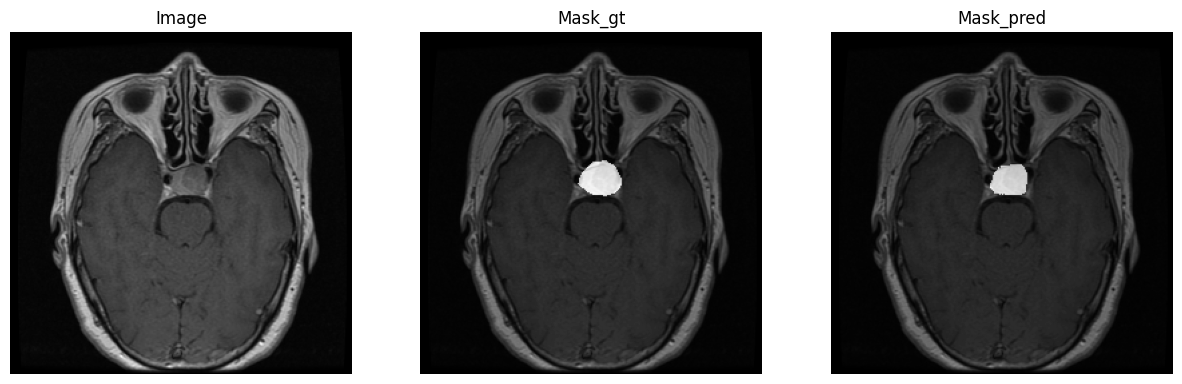

1/1 [==============================] - 0s 23ms/step


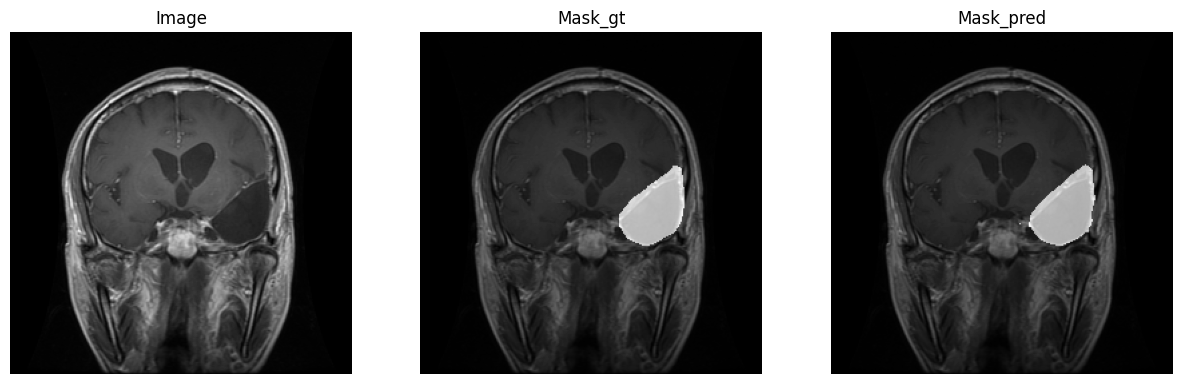

1/1 [==============================] - 0s 21ms/step


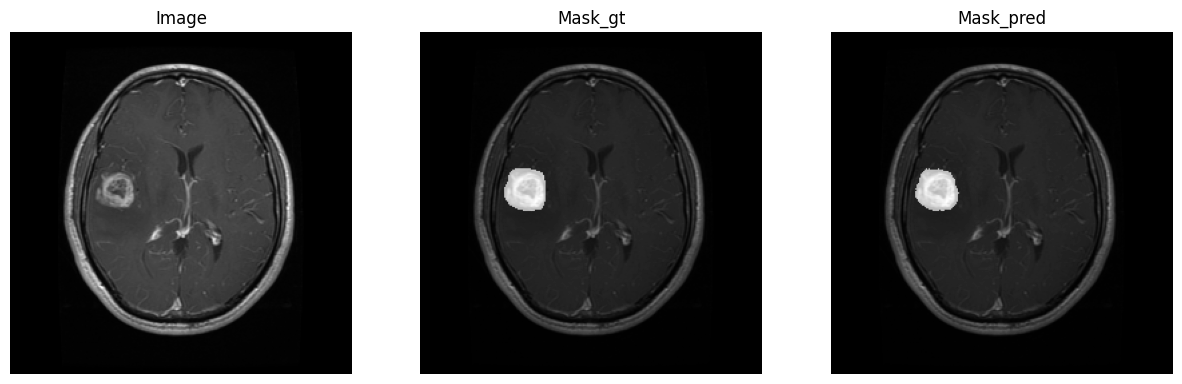

1/1 [==============================] - 0s 22ms/step


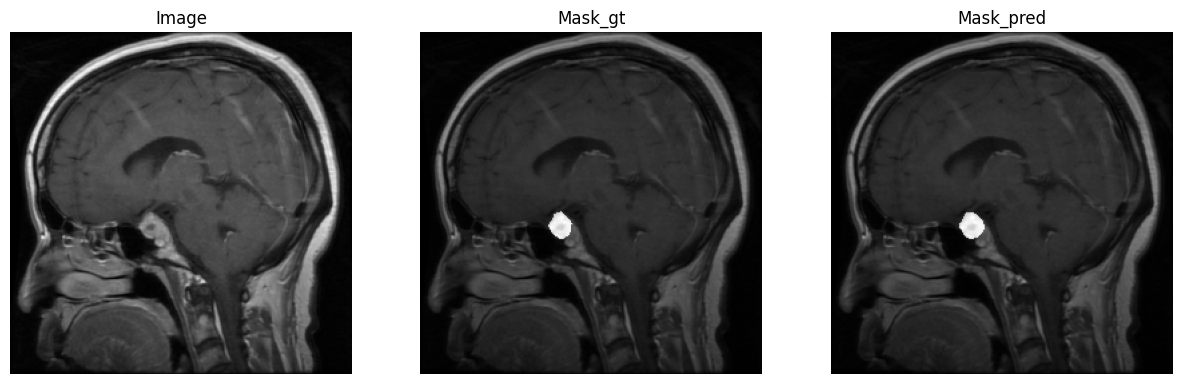

1/1 [==============================] - 0s 19ms/step


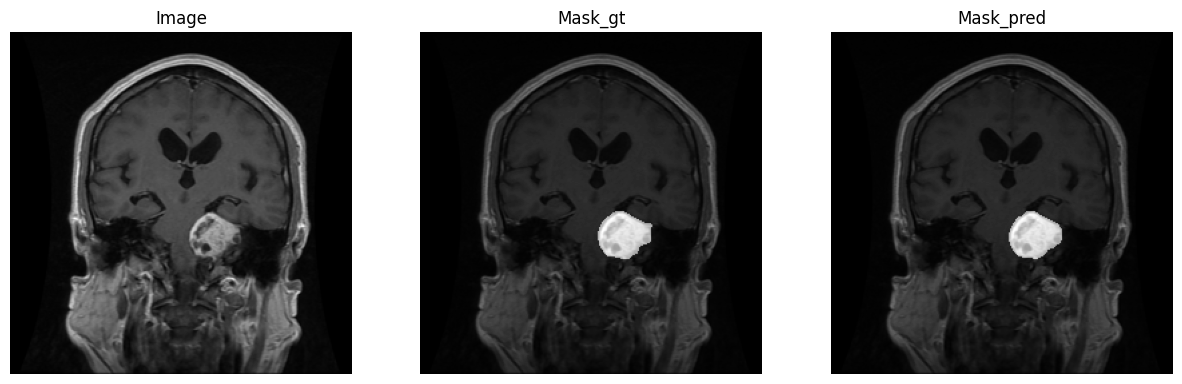

In [12]:
predictions = []
count = 0

output_dir = './output_images'
os.makedirs(output_dir, exist_ok=True)

for model_path in [f for f in os.listdir('./model_history') if f.endswith('.h5')]:
    if model_path == 'model_checkpoint_epoch_160.h5':
        model = build_unet((256, 256, 1))
        # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.load_weights('./model_history' + '/' + model_path)
        print(model_path)
    
        count = 0
        for img, mask_gt in test_dataset:
            if count >= 5:
                break
            mask_pred = model.predict(img)
            
            overlay = np.zeros_like(img)
            overlay[mask_gt > 0] = 1
            combined_gt = img * 0.5 + overlay * 0.5
            overlay = np.zeros_like(img)
            overlay[mask_pred > 1e-2] = 1
            combined_pred = img * 0.5 + overlay * 0.5
        
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            ax = axes[0]
            ax.imshow(img[1, :, :, 0], cmap='gray')
            ax.set_title('Image')
            ax.set_axis_off()
            
            ax = axes[1]
            ax.imshow(combined_gt[1, :, :, 0], cmap='gray')
            ax.set_title('Mask_gt')
            ax.set_axis_off()
            
            ax = axes[2]
            ax.imshow(combined_pred[1, :, :, 0], cmap='gray')
            ax.set_title('Mask_pred')
            ax.set_axis_off()
        
        # Save the figure
            output_path = os.path.join(output_dir, f'prediction_{count}.png')
            plt.savefig(output_path, bbox_inches='tight')

            plt.show()
            count += 1
    

# Classification

[Build-U-Net-architecture](#Build-U-Net-architecture)

In [27]:
import matplotlib.pyplot as plt
import os
import random
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from PIL import Image

In [29]:
img_size = (256, 256)
batch_size = 32

train_dir = r'.\brain-tumor-classification\Training'
test_dir = r'.\brain-tumor-classification\Testing'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [4]:
img_size = (256, 256)
batch_size = 32

train_dir = r'.\brain-tumor-classification\Training'
test_dir = r'.\brain-tumor-classification\Testing'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',  # Automatically infer labels based on subdirectories
    label_mode='categorical',  # For multi-class classification
    batch_size=batch_size,
    image_size=img_size,
    color_mode='grayscale')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    color_mode='grayscale'
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [33]:
data.shape

TensorShape([32, 256, 256, 1])

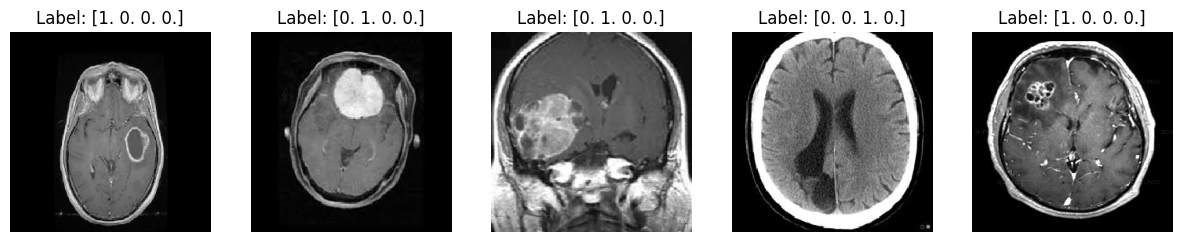

In [13]:
data, label = next(iter(test_generator))
data.shape, label.shape

import matplotlib.pyplot as plt

# Assuming data is a 4D array with shape (32, 256, 256, 1)
# and labels is a 2D array with shape (32, 4)
# Modify `data` and `labels` as needed

def visualize_examples(data, labels, num_examples=5):
    plt.figure(figsize=(15, 3))  # Adjust figure size if necessary

    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        # Display the 2D image
        plt.imshow(data[i, :, :, 0], cmap='gray')  # Use cmap='gray' for single-channel data
        plt.axis("off")
        
        # Display the label as a title
        plt.title(f"Label: {labels[i]}")

    plt.show()

# Example usage
visualize_examples(data, label, num_examples=5)


In [14]:
# from tensorflow.keras import backend as K
# K.clear_session()
from tensorflow.keras.models import Model

model_path = 'model_checkpoint_epoch_160.h5' # Best Segmentation Model
model = build_unet((256, 256, 1))
model.load_weights('./model_history' + '/' + model_path)

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

for layer in model.layers[:13]:  
    layer.trainable = True      # Unfreeze the first 12 layers

encoder_output = model.layers[13].output
print(model.layers[13].name)

# Add pooling to reduce the spatial dimensions
x = layers.GlobalAveragePooling2D()(encoder_output)
# x = layers.Flatten()(encoder_output)

# Add dense layers for classification
x = layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)  # Adjust `num_classes` to your problem

# Define the new model
classification_model = Model(inputs=model.input, outputs=output)
classification_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

dropout_9


In [ ]:
# Fit to your classification data
checkpoint_callback1 = ModelCheckpoint(
    "./model_history_classification/model_checkpoint_epoch_{epoch:02d}.h5",  # Save file name with epoch number
    save_freq=900,  # Save every epoch
    save_weights_only=True)

checkpoint_callback2 = ModelCheckpoint(
    "./model_history_classification/model_checkpoint_epoch_{epoch:02d}.h5",  # Save file name with epoch number
    monitor='val_accuracy',  # Save every epoch
    save_best_only=True,
    save_weights_only=False,
    mode='max')

classification_model.fit(train_generator, epochs=200, validation_data=test_generator, callbacks=[checkpoint_callback1, checkpoint_callback2])

In [59]:
model_path = 'model_checkpoint_epoch_177.h5'
classification_model.load_weights('./model_history_classification' + '/' + model_path)
classification_model.evaluate(test_generator)
classification_model.evaluate(train_generator)

90/90 [==============================] - 44s 489ms/step - loss: 0.0679 - accuracy: 0.9871


[0.06791453808546066, 0.9871079921722412]

In [40]:
# Four types classification
test_generator.class_indices   

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [39]:
count = 0
for data, label in test_generator:
    if count > 5:
        break
    print(tf.argmax(classification_model.predict(data), 1))
    count += 1

1/1 [==============================] - 0s 27ms/step
tf.Tensor([2 2 2 0 1 0 3 1 3 2 2 2 2 1 2 3 0 1 1 1 1 1 2 2 3 2 0 2 2 2 0 2], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 17ms/step
tf.Tensor([1 3 2 1 0 3 2 1 2 1 0 0 2 2 2 1 2 1 1 3 0 2 0 1 0 1 0 2 1 1 2 1], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 22ms/step
tf.Tensor([1 3 3 0 1 2 1 0 2 1 1 2 3 3 3 0 3 1 2 1 3 1 1 1 0 1 2 3 1 1 1 2], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 19ms/step
tf.Tensor([1 3 1 2 2 2 1 3 3 1 0 1 2 2 3 1 2 1 2 2 3 2 2 1 0 1 0 1 2 2 0 0], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 17ms/step
tf.Tensor([1 1 0 2 2 3 2 1 1 1 2 1 1 2 2 1 3 1 2 1 1 1 2 1 1 2 0 1 1 1 1 1], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 18ms/step
tf.Tensor([2 2 2 2 2 3 2 2 3 1 2 3 1 2 2 2 2 1 1 2 1 2 1 0 2 2 3 2 2 1 2 2], shape=(32,), dtype=int64)


In [70]:
print(model_names)

['model_checkpoint_epoch_01.h5', 'model_checkpoint_epoch_02.h5', 'model_checkpoint_epoch_04.h5', 'model_checkpoint_epoch_06.h5', 'model_checkpoint_epoch_09.h5', 'model_checkpoint_epoch_10.h5', 'model_checkpoint_epoch_100.h5', 'model_checkpoint_epoch_110.h5', 'model_checkpoint_epoch_120.h5', 'model_checkpoint_epoch_13.h5', 'model_checkpoint_epoch_130.h5', 'model_checkpoint_epoch_14.h5', 'model_checkpoint_epoch_140.h5', 'model_checkpoint_epoch_150.h5', 'model_checkpoint_epoch_16.h5', 'model_checkpoint_epoch_160.h5', 'model_checkpoint_epoch_170.h5', 'model_checkpoint_epoch_177.h5', 'model_checkpoint_epoch_18.h5', 'model_checkpoint_epoch_180.h5', 'model_checkpoint_epoch_190.h5', 'model_checkpoint_epoch_20.h5', 'model_checkpoint_epoch_200.h5', 'model_checkpoint_epoch_24.h5', 'model_checkpoint_epoch_30.h5', 'model_checkpoint_epoch_39.h5', 'model_checkpoint_epoch_40.h5', 'model_checkpoint_epoch_41.h5', 'model_checkpoint_epoch_43.h5', 'model_checkpoint_epoch_45.h5', 'model_checkpoint_epoch_50.

In [103]:
f'model_history_classification\{n}'

'model_history_classification\\model_checkpoint_epoch_01.h5'

In [108]:
# Plot Model Loss vs. Epochs during model training
import re

# Define the function to extract the first number found in a string 
def extract_number(string):
    match = re.search(r'\d+', string)
    return int(match.group()) if match else float('inf')

# list directory of history
model_names = os.listdir('model_history_classification')
sorted_model_names = sorted(model_names, key=extract_number)
# print(sorted_model_names)

x = []
y1 = []
y2 = []
for n in sorted_model_names:
    num = extract_number(n)
    
    model = tf.keras.models.load_model(f'model_history_classification\{n}')
    val_accuracy = model.evaluate(test_generator)[1]
    accuracy = model.evaluate(train_generator)[1]
    
    x.append(num)
    y1.append(val_accuracy)
    y2.append(accuracy)

90/90 [==============================] - 20s 226ms/step - loss: 0.3828 - accuracy: 0.9279


ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000023EF80E5520>.

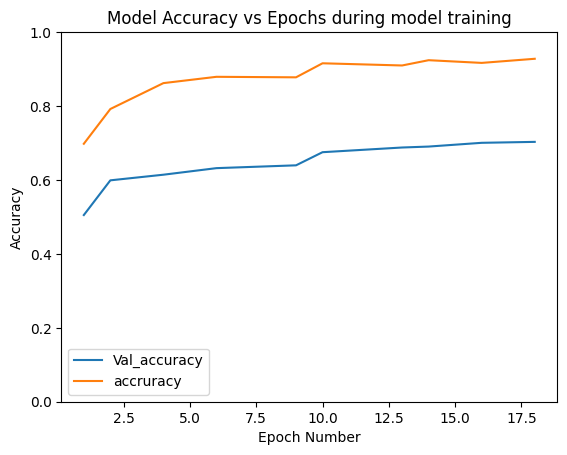

In [117]:
plt.plot(x, y1, label = 'Val_accuracy')
plt.plot(x, y2, label = 'accruracy')
plt.title('Model Accuracy vs Epochs during model training')
plt.xlabel('Epoch Number')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.legend()
#plt.show()

plt.savefig('Model_Accuracy_vs_Epochs.png', format='png', dpi=300)

# ResourceExhaustedError 

In [48]:
def load_and_preprocess(img_path, mask_path, target_size):
    
    img = Image.open(imagepath + '/' + image_file).convert('L').resize(target_size, Image.LANCZOS) 
    mask = Image.open(maskpath + '/' + mask_file).convert('L').resize(target_size, Image.LANCZOS) 

    img_array = np.array(img)
    mask_array = np.array(mask)
    print(img_array.shape, mask_array.shape)

    img_array = img_array / 255.0
    mask_array = mask_array / 255.0

    img_array = img_array.reshape(1, 1, *target_size)
    mask_array = mask_array.reshape(1, 1, *target_size)
    print(img_array.shape)
    
    return img_array, mask_array

imagepath = './brain-tumor-segmentation/images'
maskpath = './brain-tumor-segmentation/masks'

target_size = (256, 256)
img_arrays = np.empty((0, 1, *target_size))
mask_arrays = np.empty((0, 1, *target_size))

for image_file, mask_file in zip(image_files, mask_files):
    img_array, mask_array = load_and_preprocess(imagepath, maskpath, target_size)
    img_arrays = tf.concat((img_arrays, img_array), axis=0)
    mask_arrays = tf.concat((mask_arrays, mask_array), axis=0)
    print(img_arrays.shape)

(256, 256) (256, 256)
(1, 1, 256, 256)
(1, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(2, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(3, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(4, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(5, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(6, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(7, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(8, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(9, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(10, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(11, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(12, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(13, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(14, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(15, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(16, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(17, 1, 256, 256)
(256, 256) (256, 256)
(1, 1, 256, 256)
(

ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[2503,1,256,256] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat